In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, RandomFlip, RandomBrightness, RandomContrast, Rescaling,
    Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, RandomZoom
)
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import backend as k
import keras_tuner as kt

2025-08-17 20:28:28.169326: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-17 20:28:28.803134: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-17 20:28:40.160671: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [29]:
seed = 1000
batch_size = 4
img_size = 224

In [30]:
train_ds, val_ds = image_dataset_from_directory(
    directory="./dataset",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=False,
    verbose=True,
)

Found 1265 files belonging to 2 classes.
Using 1012 files for training.
Using 253 files for validation.


In [31]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def build_model(hp):
    k.clear_session()
    data_augmentation = Sequential([
        RandomFlip(mode="horizontal", seed=seed),
        RandomBrightness(factor=0.2, seed=seed),
        RandomContrast(factor=0.2, seed=seed),
        RandomZoom(0.2, seed=seed)
    ])

    hp_kernel_size_conv_1 = hp.Choice('kernel_size_conv_1', values=[3, 5])

    hp_filters_conv_2 = hp.Int('filters_conv_2', min_value=16, max_value=64, step=16)
    hp_kernel_size_conv_2 = hp.Choice('kernel_size_conv_2', values=[3, 5])

    hp_filters_conv_3 = hp.Int('filters_conv_3', min_value=16, max_value=128, step=16)
    hp_kernel_size_conv_3 = hp.Choice('kernel_size_conv_3', values=[3, 5])

    hp_units_dense_1 = hp.Int('units_dense_1', min_value=64, max_value=1024, step=64)
    hp_units_dense_2 = hp.Int('units_dense_2', min_value=64, max_value=1024, step=64)

    hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)

    model = Sequential([
        Input(shape=(img_size, img_size, 3)),
        data_augmentation,
        Rescaling(1./255),
        Conv2D(filters=32, kernel_size=(hp_kernel_size_conv_1, hp_kernel_size_conv_1), activation="relu", kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=hp_filters_conv_2, kernel_size=(hp_kernel_size_conv_2, hp_kernel_size_conv_2), activation="relu", kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=hp_filters_conv_3, kernel_size=(hp_kernel_size_conv_3, hp_kernel_size_conv_3), activation="relu", kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=hp_units_dense_1, activation="relu", kernel_initializer="he_normal"),
        Dropout(hp_dropout_1),
        Dense(units=hp_units_dense_2, activation="relu", kernel_initializer="he_normal"),
        Dense(units=1, activation="sigmoid")
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[BinaryAccuracy, Precision, Recall])
    
    return model

In [33]:
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_binary_accuracy', direction='max'), # Otimizar para a maior acurácia de validação
    max_trials=20, # Número máximo de combinações de hiperparâmetros a serem testadas
    directory='keras_tuner_dir/test-1', # Diretório para salvar os resultados do tuner
    project_name='binary_classification_tuning',
    overwrite=True # Sobrescrever resultados anteriores se o diretório já existir
)

In [34]:
print("\n--- Iniciando a busca de hiperparâmetros com Keras Tuner ---")
tuner.search(train_ds,
             validation_data=val_ds,
             epochs=10, # Você pode usar um número menor de épocas para o tuning para acelerar
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Trial 2 Complete [00h 00m 11s]

Best val_binary_accuracy So Far: None
Total elapsed time: 00h 00m 22s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
3                 |5                 |kernel_size_conv_1
32                |32                |filters_conv_2
5                 |3                 |kernel_size_conv_2
64                |96                |filters_conv_3
3                 |5                 |kernel_size_conv_3
1024              |1024              |units_dense_1
960               |192               |units_dense_2
0.4               |0.2               |dropout_1
0.01              |0.001             |learning_rate



2025-08-17 20:49:13.298993: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 196.00MiB (rounded to 205520896)requested by op StatelessTruncatedNormalV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-08-17 20:49:13.299348: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1049] BFCAllocator dump for GPU_0_bfc
2025-08-17 20:49:13.299378: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (256): 	Total Chunks: 9724, Chunks in use: 9723. 2.37MiB allocated for chunks. 2.37MiB in use in bin. 55.7KiB client-requested in use in bin.
2025-08-17 20:49:13.299385: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (512): 	Total Chunks: 53, Chunks in use: 53. 32.5KiB allocated for chunks. 32.5KiB in use in bin. 28.9KiB client-reques

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras_tuner/src/engine/tuner.py", line 155, in _build_hypermodel
    model = self.hypermodel.build(hp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_5164/2780587866.py", line 23, in build_model
    model = Sequential([
            ^^^^^^^^^^^^
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras/src/models/sequential.py", line 76, in __init__
    self._maybe_rebuild()
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras/src/models/sequential.py", line 149, in _maybe_rebuild
    self.build(input_shape)
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras/src/layers/layer.py", line 231, in build_wrapper
    original_build_method(*args, **kwargs)
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras/src/models/sequential.py", line 195, in build
    x = layer(x)
        ^^^^^^^^
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/mnt/c/Users/henri/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/random.py", line 67, in truncated_normal
    return tf.random.stateless_truncated_normal(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tensorflow.python.framework.errors_impl.ResourceExhaustedError: {{function_node __wrapped__StatelessTruncatedNormalV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[50176,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessTruncatedNormalV2]


In [18]:
# Obter o melhor modelo e seus hiperparâmetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- Melhores hiperparâmetros encontrados: ---")
print(best_hp.values)


--- Melhores hiperparâmetros encontrados: ---
{'kernel_size_conv_1': 5, 'filters_conv_2': 192, 'kernel_size_conv_2': 5, 'filters_conv_3': 64, 'kernel_size_conv_3': 3, 'units_dense_1': 832, 'units_dense_2': 320, 'units_dense_3': 704, 'dropout_1': 0.4, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.0001}


In [19]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir/test-1\binary_classification_tuning
Showing 10 best trials
Objective(name="val_binary_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
kernel_size_conv_1: 5
filters_conv_2: 192
kernel_size_conv_2: 5
filters_conv_3: 64
kernel_size_conv_3: 3
units_dense_1: 832
units_dense_2: 320
units_dense_3: 704
dropout_1: 0.4
dropout_2: 0.30000000000000004
learning_rate: 0.0001
Score: 0.8221343755722046

Trial 09 summary
Hyperparameters:
kernel_size_conv_1: 3
filters_conv_2: 32
kernel_size_conv_2: 5
filters_conv_3: 320
kernel_size_conv_3: 5
units_dense_1: 192
units_dense_2: 320
units_dense_3: 640
dropout_1: 0.4
dropout_2: 0.30000000000000004
learning_rate: 0.0001
Score: 0.8142292499542236

Trial 17 summary
Hyperparameters:
kernel_size_conv_1: 5
filters_conv_2: 128
kernel_size_conv_2: 3
filters_conv_3: 256
kernel_size_conv_3: 5
units_dense_1: 576
units_dense_2: 960
units_dense_3: 64
dropout_1: 0.2
dropout_2: 0.4
learning_rate: 0.0001
Score: 0.814

In [ ]:
trials = tuner.oracle.get_best_trials(num_trials=tuner.oracle.max_trials) # Pega todos os trials

num_trials = tuner.oracle.max_trials or len(tuner.oracle.trials)
trials = tuner.oracle.get_best_trials(num_trials=num_trials)

data = []
for trial in trials:
    trial_data = {
        'trial_id': trial.trial_id,
        'score': trial.score,
        'status': trial.status
    }

    for hp_name, hp_value in trial.hyperparameters.values.items():
        trial_data[hp_name] = hp_value

    if trial.metrics and hasattr(trial.metrics, "get_last_step_metrics"):
        last_epoch_metrics = trial.metrics.get_last_step_metrics()
        for metric_name, metric_value_obj in last_epoch_metrics.items():
            value = getattr(metric_value_obj, "value", None)
            if value is not None:
                trial_data[f'final_{metric_name}'] = value

    data.append(trial_data)

df_trials = pd.DataFrame(data)
print(df_trials.head())

NameError: name 'tuner' is not defined

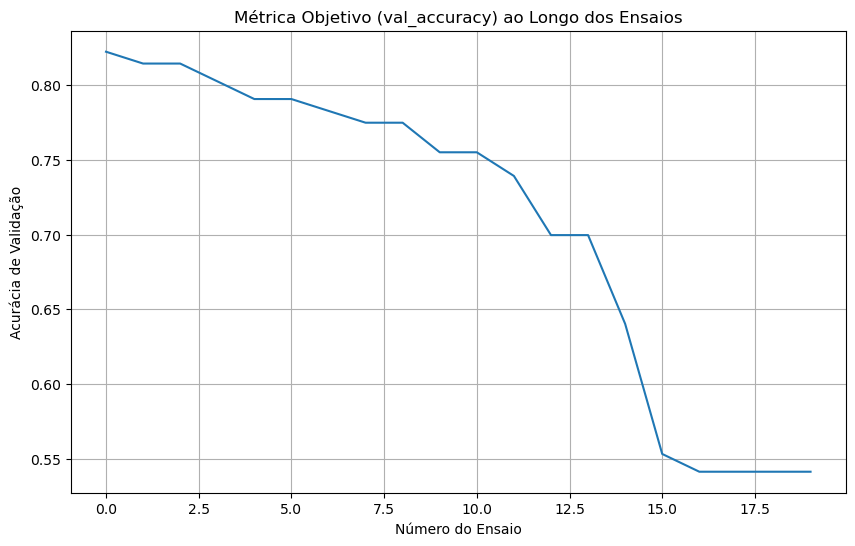

In [23]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_trials.index, y='score', data=df_trials)
plt.title('Métrica Objetivo (val_accuracy) ao Longo dos Ensaios')
plt.xlabel('Número do Ensaio')
plt.ylabel('Acurácia de Validação')
plt.grid(True)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_10348\3097500041.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_trials, x='trial_id', y='score', palette='mako')


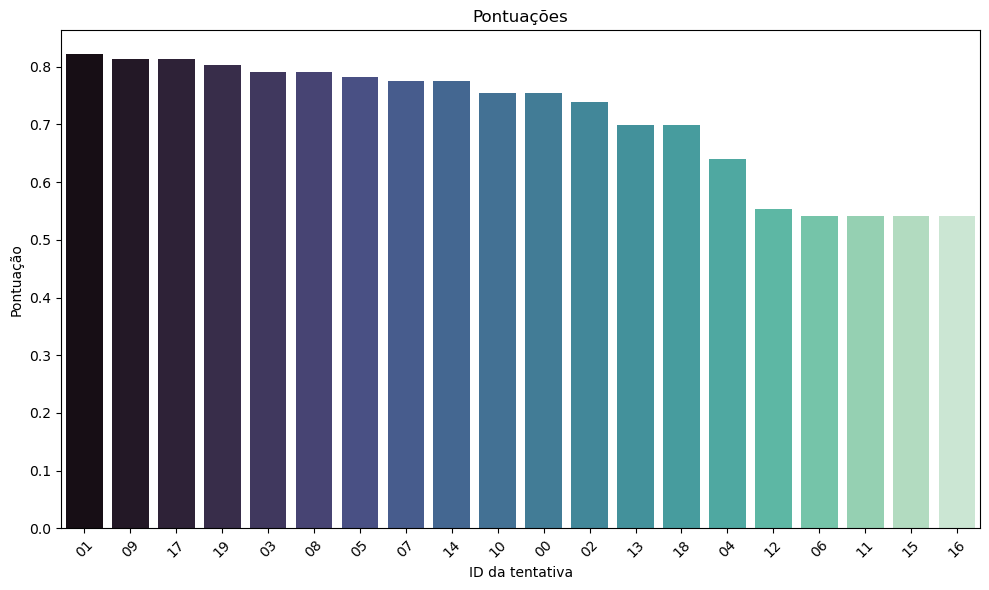

In [27]:
top_trials = df_trials.sort_values(by='score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_trials, x='trial_id', y='score', palette='mako')
plt.title('Pontuações')
plt.xlabel('ID da tentativa')
plt.ylabel('Pontuação')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

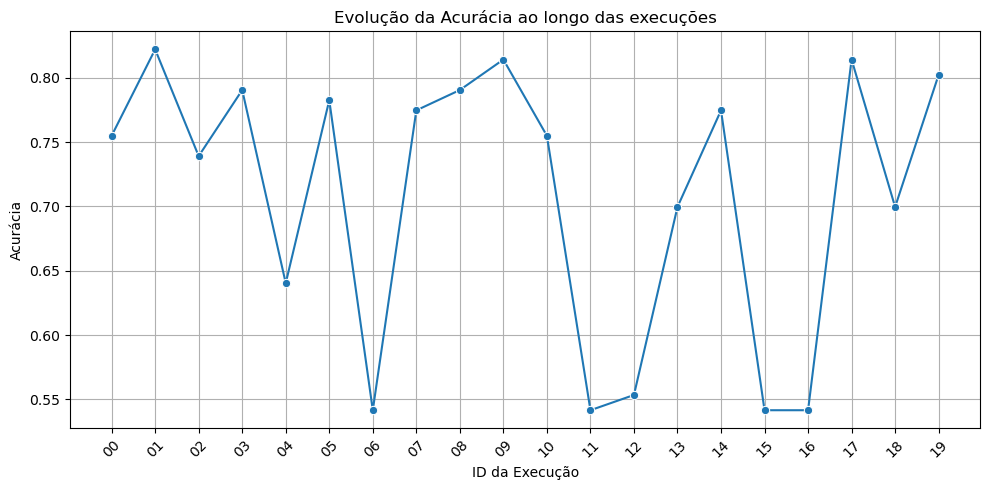

In [29]:
df_trials_sorted = df_trials.sort_values(by='trial_id')

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_trials_sorted, x='trial_id', y='score', marker='o')
plt.title('Evolução da Acurácia ao longo das execuções')
plt.xlabel('ID da Execução')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()